# Temporal Gap Statistic
## Requirements 

The following list shows the required libraries to run this notebook:

* fNonlinear 
* foreach 
* parallel 
* Scikit-Learn 
* doParallel 
* dtw
* gdata
* tseriesChaos
* fractal

You can install them by running the R command "install.packages()". The packages "fractal" and "fractal" can be installed by using the following commands (please place them into a separate cell).


r <- getOption("repos")<br>
r["CRAN"] <- "https://vps.fmvz.usp.br/CRAN/"<br>
options(repos = r)<br>

pkg.install <- function(x){<br>
&emsp; if (!suppressWarnings(require(x,character.only = TRUE)))<br>
&emsp; {<br>
&emsp;&emsp; install.packages(x,dep=TRUE)<br>
&emsp;&emsp; if(!require(x,character.only = TRUE)) stop("Package not found")<br>
&emsp;}<br>
}<br>

#determinitic time series<br>
pkg.install("tseriesChaos")<br>
pkg.install("fractal")<br>


## Loading Dependencies

After installing all libs, just load them and our source code by running the following commands:

In [1]:
source("src/dynSys.R")
source("src/timeseries_gap_statistic.R")

Loading required package: fNonlinear

Loading required package: timeDate

Loading required package: timeSeries

Loading required package: fBasics

Loading required package: parallel

Loading required package: iterators

Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:timeSeries’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loaded dtw v1.22-3. See ?dtw for help, citation("dtw") for use in publication.


gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.


Attaching package: ‘gdata’


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith


Loading required package: splus2R


Attaching 

## Creating a synthetic dataset

We created the dataset by combining a set of deterministic time series along with stochastic ones, using different noise levels.

The deterministic time series were based four chaotic systems: (i) Lorenz; (ii) Rössler; and (iii) Logistic.

In [2]:
#Create deterministic time series

obs <- 20000
lorenz.series <- function(noise=0.0, ts.size=2000){
  
  lor.data<-read.table("data/lor63.dat")$V1
  lor.noise <- lor.data + rnorm(obs, sd=noise)
  
  #Normalize time series
  lor.noise = (lor.noise - min(lor.noise))/(max(lor.noise) - min(lor.noise))
  lorTs <- c()
  size <- length(lor.noise)/ts.size
  
  numCores <- detectCores()
  registerDoParallel(numCores) 
  lorTs<-foreach(i = 0:(size-1), .combine=rbind) %dopar% {
    c(lor.noise[(i*ts.size+1):((i+1)*ts.size)])
  }
  stopImplicitCluster()

  lorTs
}

rossler.series <- function(noise=0.0, ts.size=2000){
  
  ros.data <- read.table("data/ros.dat")$V1[1:obs]  
  ros.noise <- ros.data + rnorm(obs, sd=noise)

  
  #Normalize time series
  ros.noise = (ros.noise - min(ros.noise))/(max(ros.noise) - min(ros.noise))
  rosTs <- c()
  size <- length(ros.noise)/ts.size
  
  numCores <- detectCores()
  registerDoParallel(numCores) 
  rosTs<-foreach(i = 0:(size-1), .combine=rbind) %dopar% {
    c(ros.noise[(i*ts.size+1):((i+1)*ts.size)])
  }
  stopImplicitCluster()
  
  rosTs
}

logistic.series <- function(noise=0.0, ts.size=2000){
  
  create.log<-function(x=0.5, r=3.8, size=obs){
    ts.data<-c(x)
    for(i in 2:size){
      ts.data[i]<-r*ts.data[i-1]*(1-ts.data[i-1])
    }
    ts.data
    
  }
  
  
  log.data <- read.table("data/log.dat")$V1
  log.noise <- log.data + rnorm(obs, sd=noise)
  
  #Normaliza time series
  log.noise = (log.noise - min(log.noise))/(max(log.noise) - min(log.noise))
  
  logTs <- c()
  size <- length(log.noise)/ts.size
  
  numCores <- detectCores()
  registerDoParallel(numCores) 
  logTs<-foreach(i = 0:(size-1), .combine=rbind) %dopar% {
    c(log.noise[(i*ts.size+1):((i+1)*ts.size)])
  
  }
  stopImplicitCluster()
  
  logTs
}

In [3]:
ts.size <- 2000
noise <- 0.1
lor = lorenz.series(noise=noise, ts.size=ts.size)
ros = rossler.series(noise=noise, ts.size=ts.size)
log = logistic.series(noise=noise, ts.size=ts.size)

## Visualizing our synthetic time series

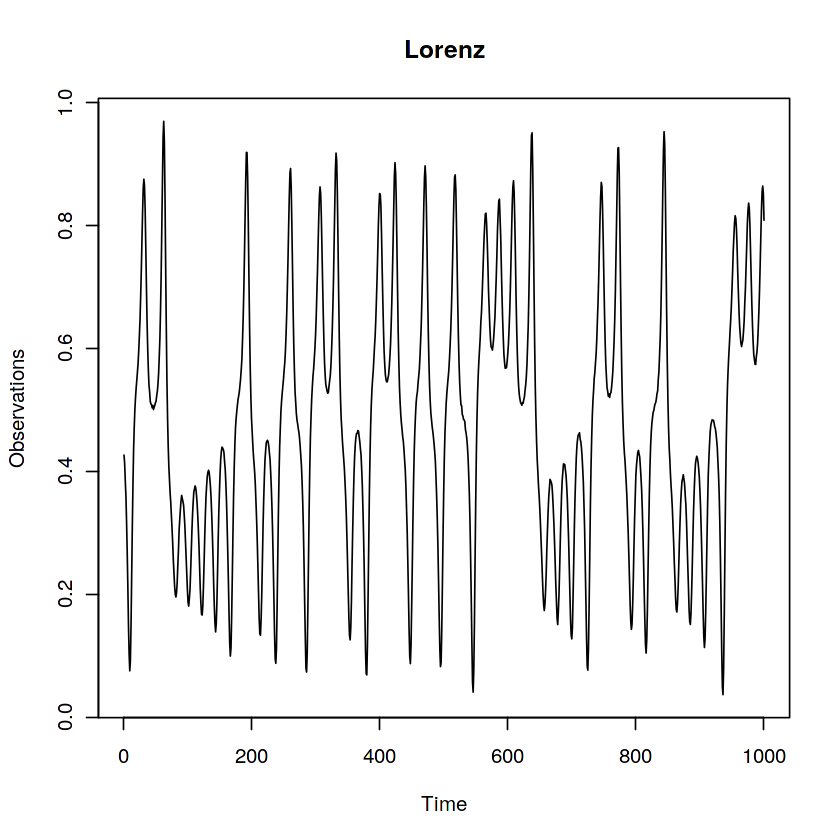

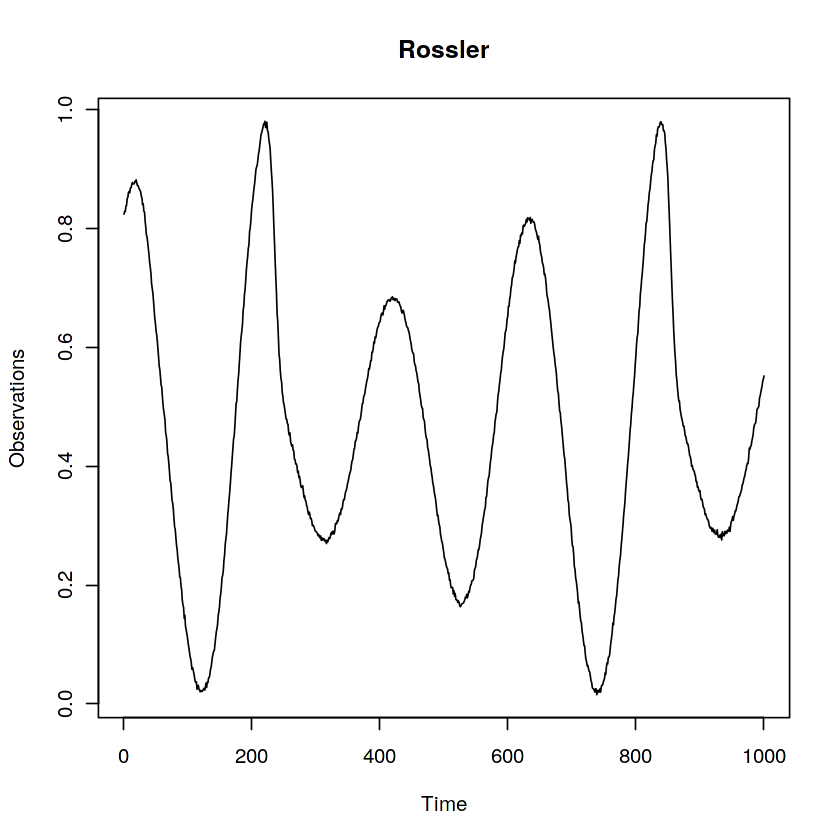

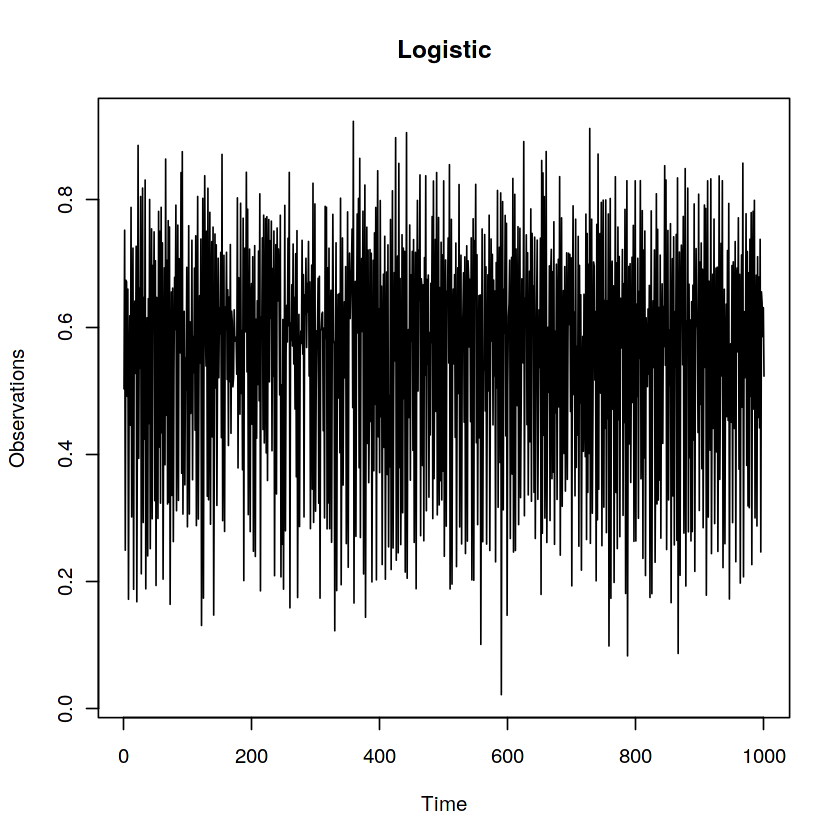

In [4]:
# Ploting deterministics series
plot.ts(lor[10,1:1000], axes=TRUE, frame.plot=TRUE, xlab="Time", ylab="Observations", main='Lorenz') 
plot.ts(ros[10,1:1000], axes=TRUE, frame.plot=TRUE, xlab="Time", ylab="Observations", main='Rossler') 
plot.ts(log[10,1:1000], axes=TRUE, frame.plot=TRUE, xlab="Time", ylab="Observations", main='Logistic') 

## Next, we create a matrix attribute-value with those time series, in which rows represent time series and columns their attributes

In [5]:
#Combining Time Series

ts <- c()
ts = rbind(ts,lor)
ts = rbind(ts,ros)
ts = rbind(ts,log)

## Before starting our methods, we use DTW to create a distance matrix between pairs of time series

In [6]:
# Create dissimilarity matrix

diss<-dtw.matrix(ts)

## Then, we also need to transform all time series into their phase space

In [7]:
# Representing Space Phase
data <- createMatrixData(ts)
data

Max dim: 2 


V1/0       V1/1      
 [1,] 0.32972611 0.37726688
 [2,] 0.37726688 0.41251761
 [3,] 0.41251761 0.43888727
 [4,] 0.43888727 0.45215477
 [5,] 0.45215477 0.46051582
 [6,] 0.46051582 0.46541959
 [7,] 0.46541959 0.46507331
 [8,] 0.46507331 0.46256834
 [9,] 0.46256834 0.46108445
[10,] 0.46108445 0.45053712
[11,] 0.45053712 0.44339420
[12,] 0.44339420 0.42990012
[13,] 0.42990012 0.40952101
[14,] 0.40952101 0.38575158
[15,] 0.38575158 0.35200303
[16,] 0.35200303 0.31158907
[17,] 0.31158907 0.25307635
[18,] 0.25307635 0.19474037
[19,] 0.19474037 0.13051615
[20,] 0.13051615 0.08203965
[21,] 0.08203965 0.06454312
[22,] 0.06454312 0.09684970
[23,] 0.09684970 0.17186112
[24,] 0.17186112 0.25082920
[25,] 0.25082920 0.33898654
[26,] 0.33898654 0.40592416
[27,] 0.40592416 0.45616277
[28,] 0.45616277 0.49633884
[29,] 0.49633884 0.52057036
[30,] 0.52057036 0.54117144
[31,] ⋮          ⋮         
[32,] 0.2816481  0.6053219 
[33,] 0.6053219  0.7819621 
[34,] 0.7819621  0.1901553 
[35,] 0.1901553  0.6338671 
[36,] 0.6338671  0.7378335 
[37,] 0.7378335  0.4743686 
[38,] 0.4743686  0.8315200 
[39,] 0.8315200  0.1817074 
[40,] 0.1817074  0.5101826 
[41,] 0.5101826  0.7207601 
[42,] 0.7207601  0.4081951 
[43,] 0.4081951  0.6992683 
[44,] 0.6992683  0.4502412 
[45,] 0.4502412  0.7633508 
[46,] 0.7633508  0.2740876 
[47,] 0.2740876  0.5455700 
[48,] 0.5455700  0.8000632 
[49,] 0.8000632  0.2228641 
[50,] 0.2228641  0.6201663 
[51,] 0.6201663  0.8200359 
[52,] 0.8200359  0.5186425 
[53,] 0.5186425  0.7364558 
[54,] 0.7364558  0.3830925 
[55,] 0.3830925  0.7108280 
[56,] 0.7108280  0.5978119 
[57,] 0.5978119  0.7273314 
[58,] 0.7273314  0.1601319 
[59,] 0.1601319  0.5062281 
[60,] 0.5062281  0.7802610 
[61,] 0.7802610  0.3491793

In [8]:
#Run Temporal Gap Statistic

gap_stat <- clusGap_timeseries(ts, diss, FUN = pam, K.max = 10, B = 10, spaceH0 = 'original', type='dtw')


Type:  dtw
 PAM para k = 1
 logW:  0.5122016
 PAM para k = 2
 logW:  0.3657559
 PAM para k = 3
 logW:  0.2947896
 PAM para k = 4
 logW:  0.2774265
 PAM para k = 5
 logW:  0.2600732
 PAM para k = 6
 logW:  0.2428318
 PAM para k = 7
 logW:  0.2257244
 PAM para k = 8
 logW:  0.2085937
 PAM para k = 9
 logW:  0.1915734
 PAM para k = 10
 logW:  0.1745123
Gerando Monte Carlo para B:  1
 SISTEMAS DINÂMICOS
Gerando séries uniformes na dimensão -  Max dim: 2 

Criando matriz de distância para as séries uniformes
 PAM para k = 1
 logWks:  0.7759954
 PAM para k = 2
 logWks:  0
 PAM para k = 3
 logWks:  0
 PAM para k = 4
 logWks:  0
 PAM para k = 5
 logWks:  0
 PAM para k = 6
 logWks:  0
 PAM para k = 7
 logWks:  0
 PAM para k = 8
 logWks:  0
 PAM para k = 9
 logWks:  0
 PAM para k = 10
 logWks:  0
Gerando Monte Carlo para B:  2
 SISTEMAS DINÂMICOS
Gerando séries uniformes na dimensão -  Max dim: 2 

Criando matriz de distância para as séries uniformes
 PAM para k = 1
 logWks:  0.7759954
 PAM par

In [9]:
# Show results
print.clusGap(gap_stat)


Clustering Gap statistic ["clusGap"] from call:
clusGap_timeseries(x = ts, diss = diss, FUNcluster = pam, K.max = 10,     B = 10, spaceH0 = "original", type = "dtw")
B=10 simulated reference sets, k = 1..10; spaceH0="original"

 --> Number of clusters (method 'firstSEmax', SE.factor=1): 3

 --> Number of clusters (method 'firstmax'): 3
           logW    E.logW       gap       SE.sim
 [1,] 0.5122016 0.7761910 0.2639894 0.0008885288
 [2,] 0.3657559 0.7490583 0.3833025 0.0008915136
 [3,] 0.2947896 0.7217792 0.4269896 0.0009415288
 [4,] 0.2774265 0.6944158 0.4169893 0.0009514449
 [5,] 0.2600732 0.6672478 0.4071745 0.0010451510
 [6,] 0.2428318 0.6401726 0.3973408 0.0010521577
 [7,] 0.2257244 0.6131822 0.3874578 0.0009893998
 [8,] 0.2085937 0.5862123 0.3776185 0.0008622212
 [9,] 0.1915734 0.5591463 0.3675729 0.0007215906
[10,] 0.1745123 0.5321699 0.3576576 0.0007355461


[1] 3 3

## Next, we plot the statistics used to calculate the temporal gap statistic

In [10]:
# The following libs are just used to visualize the statistics
library(reshape)
library(ggplot2)
library(dplyr)
library(tidyr)

plot_GapStatistic<-function(gap_stat){
  # Gap Statistic
  df_gap <- as.data.frame.matrix(gap_stat$Tab) 
  ggplot(df_gap, aes(x=as.numeric(row.names(df_gap)), y=gap)) + 
    geom_line(colour = 'red') +
    geom_point(colour = 'red')+
    geom_errorbar(aes(ymin=gap-SE.sim, ymax=gap+SE.sim), width=.2,
                  position=position_dodge(0.05), colour = 'red') +
    xlab("Number clusters k") + ylab("Gap") +
    scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10)) +
    theme(text = element_text(size=20))
}
  
  
plot_Wk <- function(gap_stat){  
  # Wk
  df_gap <- as.data.frame.matrix(gap_stat$Tab) 
  df <- df_gap[,c(1,2)]
  df$id <- seq.int(nrow(df))
  names(df) <- tolower(names(df))
  data <- melt(df, id.vars = 'id')
  ggplot(data = data, aes(x=id,y=value,colour=variable))+ 
    geom_line() +
    geom_point() +
    xlab("Number clusters k") + ylab("Value") +
    labs(fill = "Dispersion") +
    theme(text = element_text(size=20))
}



Attaching package: ‘dplyr’


The following object is masked from ‘package:reshape’:

    rename


The following objects are masked from ‘package:gdata’:

    combine, first, last


The following objects are masked from ‘package:timeSeries’:

    filter, lag


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:reshape’:

    expand, smiths




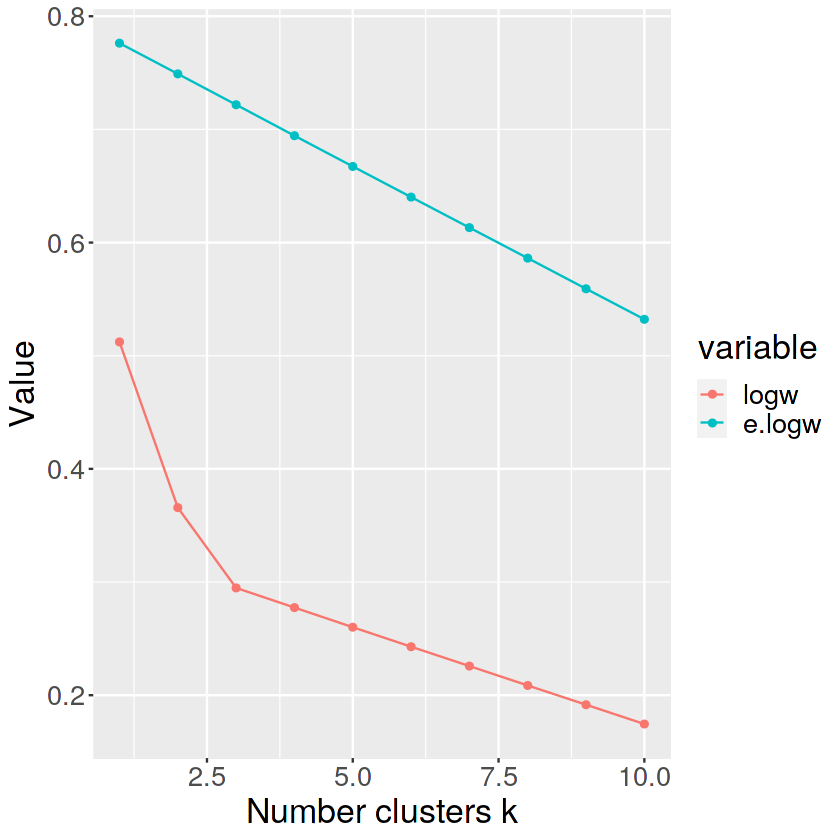

In [11]:
#The best number of groups is given when logw is lower than reference curve e.logw, corresponding to the maximization of the gap value. For example, by looking at Figure below, 
#we notice a sudden reduction of logw when k = 3. 
plot_Wk(gap_stat)

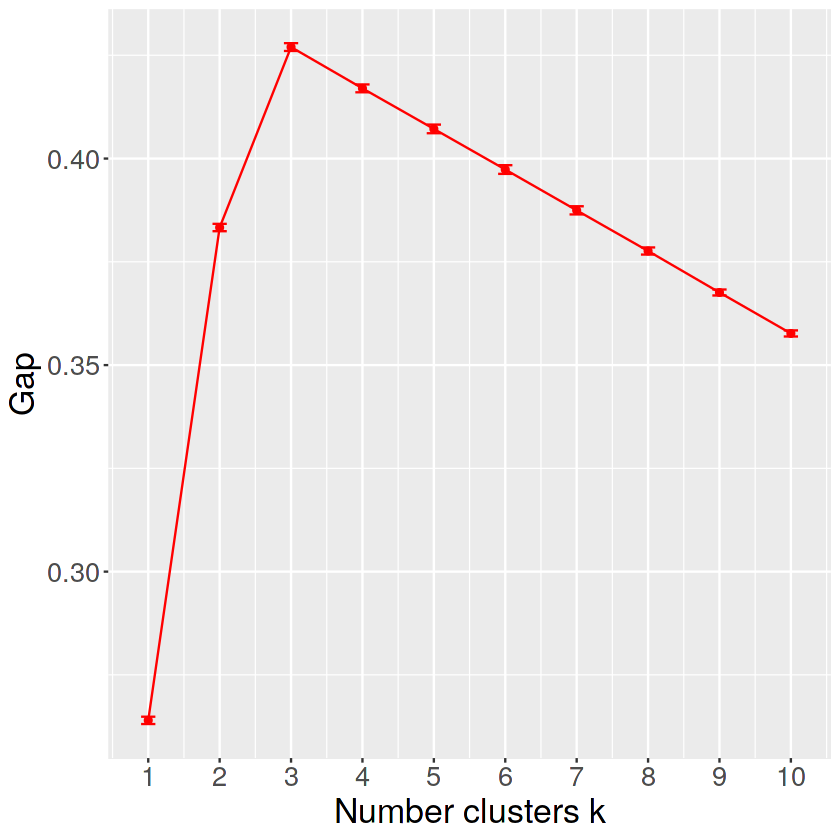

In [12]:
# The maximization of the gap value in k=3 what represent the original number of time series cluster
plot_GapStatistic(gap_stat)

### Citation

@article{RIBEIRO2021110326,<br>
title = {Temporal gap statistic: A new internal index to validate time series clustering},
journal = {Chaos, Solitons & Fractals},<br>
volume = {142},<br>
pages = {110326},<br>
year = {2021},<br>
issn = {0960-0779},<br>
doi = {https://doi.org/10.1016/j.chaos.2020.110326},<br>
url = {https://www.sciencedirect.com/science/article/pii/S0960077920307219},<br>
author = {Rosana Guimarães Ribeiro and Ricardo Rios}<br>
}

If you have any questions, feel free to contact us:

* rosana.guimaraes08@gmail.com
* ricardoar@ufba.br